In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np

In [2]:
import json

# Loading json files

with open('data/train/accounts_data_train.json', 'rb') as f:
    accounts_data = json.load(f)
    
with open('data/train/enquiry_data_train.json', 'rb') as f:
    enquiry_data = json.load(f)

In [3]:
# Loading training data CSV

train = pd.read_csv('data/train/train_flag.csv')

In [4]:
# Creating dictionary object to store the loaning history of the user

accounts_dict = {
    person[0]['uid']: person
    for person in accounts_data
}


enquiry_dict = {
    person[0]['uid']: person
    for person in enquiry_data
}


In [5]:
train.columns

Index(['uid', 'NAME_CONTRACT_TYPE', 'TARGET'], dtype='object')

# EDA

In [6]:
uid2target = {
    row['uid']: {'target': row['TARGET'], 'contract type': row['NAME_CONTRACT_TYPE']} for i, row in train.iterrows()
}

In [7]:
# Making one big dataframe for the task

temp_dict = {
    k: [] for k in enquiry_data[0][0].keys()
}
temp_dict['contract type'] = []
temp_dict['target'] = []

for person in enquiry_data:
    for enq in person:
        for k, v in enq.items():
            temp_dict[k].append(v)
        temp_dict['target'].append(uid2target[enq['uid']]['target'])
        temp_dict['contract type'].append(uid2target[enq['uid']]['contract type'])

enquiry_df = pd.DataFrame(temp_dict)

temp_dict = {
    k: [] for k in accounts_data[0][0].keys()
}
temp_dict['contract type'] = []
temp_dict['target'] = []

for person in accounts_data:
    for acc in person:
        for k, v in acc.items():
            temp_dict[k].append(v)
        temp_dict['target'].append(uid2target[acc['uid']]['target'])
        temp_dict['contract type'].append(uid2target[acc['uid']]['contract type'])

accounts_df = pd.DataFrame(temp_dict)

In [8]:
print("Number of entries in accounts data:", accounts_df.shape[0])
print("Number of entries in enquiry data:", enquiry_df.shape[0])

Number of entries in accounts data: 1245310
Number of entries in enquiry data: 1909926


In [9]:
accounts_data[0][0]

{'credit_type': 'Consumer credit',
 'loan_amount': 272745.0,
 'amount_overdue': 0.0,
 'open_date': '2018-09-22',
 'closed_date': '2020-02-22',
 'payment_hist_string': '000000000000000000000010000000000000000000000000000',
 'uid': 'AAA09044550'}

In [10]:
enquiry_data[0][0]

{'enquiry_type': 'Interbank credit',
 'enquiry_amt': 168839,
 'enquiry_date': '2020-11-08',
 'uid': 'AAA08065248'}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


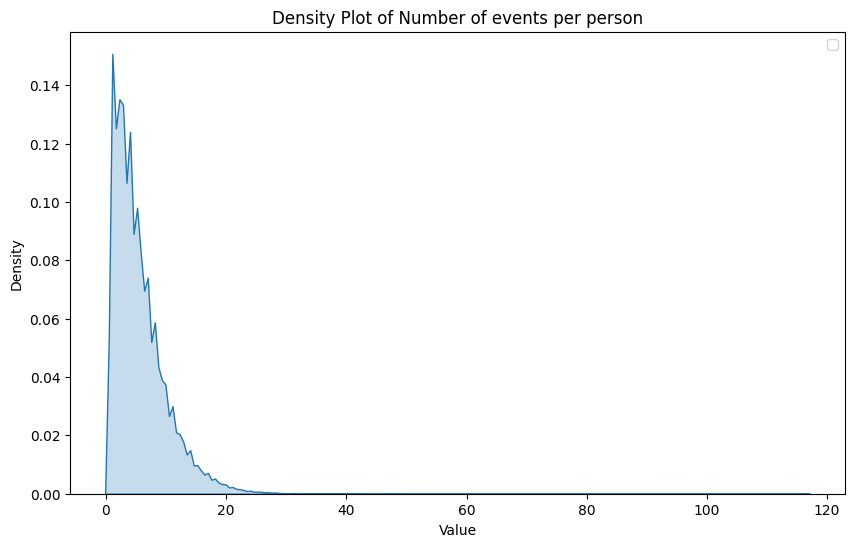

In [11]:
# I will use 120 as the standard length for the user activity

plt.figure(figsize=(10, 6))
sns.kdeplot([len(x) for x in accounts_data], label='', fill=True)
plt.title('Density Plot of Number of events per person')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# Contextual Probablistic Model

In [ ]:
# Function to create a list of dictionaries

def accounts_preprocess(accounts_data):
    if type(accounts_data[0]) == dict:
        accounts_data = [accounts_data]

    return accounts_data

def enquiry_preprocess(enquiry_data):
    if type(enquiry_data[0]) == dict:
        enquiry_data = [enquiry_data]

    return enquiry_data

In [14]:
'''
Distributions for bad loans and good loans over loan amounts and amount overdue are very similar
Except their means are distinguishable
'''

accounts_df[['loan_amount', 'amount_overdue']][accounts_df['target']==0].describe()

,loan_amount,amount_overdue
count,1.147785e+06,1.147788e+06
mean,3.557825e+05,3.021842e+01
std,1.138366e+06,6.304366e+03
min,0.000000e+00,0.000000e+00
25%,5.166000e+04,0.000000e+00
50%,1.251630e+05,0.000000e+00
75%,3.100122e+05,0.000000e+00
max,3.960000e+08,3.756681e+06


In [15]:
accounts_df[['loan_amount', 'amount_overdue']][accounts_df['target']==1].describe()

,loan_amount,amount_overdue
count,9.752200e+04,9.752200e+04
mean,3.120038e+05,1.809558e+02
std,6.887391e+05,1.000392e+04
min,0.000000e+00,0.000000e+00
25%,4.554000e+04,0.000000e+00
50%,1.200292e+05,0.000000e+00
75%,3.013890e+05,0.000000e+00
max,3.519000e+07,2.387232e+06


In [ ]:
# Model that will aggregate observations over all the events and compare them with a threshold to make prediction

# Currently, it compares the ratio of total amount overdue over the total loan taken and compare that ratio with various thresholds to find the suitable value for it
def probablistic_prediction(accounts_data, enquiry_data, thres=0.5):
    
    accounts_data = accounts_preprocess(accounts_data)
    enquiry_data = enquiry_preprocess(enquiry_data)

    predictions = []
    for peroson in accounts_data:
        overdue = 0
        total = 0
        for acc in peroson:
            overdue = 0
            total = 0
            for acc in peroson:
                overdue += acc['amount_overdue']
                total += acc['loan_amount']

        # Case where person does not have any loan records, so, we do not have any data to reject their application
        if total == 0:
            predictions += [1]
        
        else:
            predictions += [int(overdue/total > thres)]

    return predictions

In [ ]:
acc_X = [accounts_dict[x] if x in accounts_dict else [] for x in train['uid']]
enq_X = [enquiry_dict[x] if x in accounts_dict else [] for x in train['uid']]
Y = train['TARGET']

In [78]:
# Checking results with varying threshold values

# Varying threshold from 1e-5 to 9e-5 with a step size of 0.1
for thres in range(1, 10):
    predictions = probablistic_prediction(acc_X, enq_X, thres/1e3)
    print(f'ROC_AUC_Score for threshold of {thres/1e5}: {roc_auc_score(Y, predictions)}')

ROC_AUC_Score for threshold of 1e-05: 0.5238660758823447
ROC_AUC_Score for threshold of 2e-05: 0.5234758408062573
ROC_AUC_Score for threshold of 3e-05: 0.5231815819620024
ROC_AUC_Score for threshold of 4e-05: 0.5230635796422274
ROC_AUC_Score for threshold of 5e-05: 0.5229102086981673
ROC_AUC_Score for threshold of 6e-05: 0.5227206096373443
ROC_AUC_Score for threshold of 7e-05: 0.5225372520984541
ROC_AUC_Score for threshold of 8e-05: 0.5224509553584642
ROC_AUC_Score for threshold of 9e-05: 0.522244712239154


- I did many more checks for the values of thresholds, but the score didn't seemed to get any better than random guessing.
- The score is +0.02 compared to random guessing score, 0.5 because of my assumptionn that makes loan application for a person to be rejected if they do not have a loan history before.
- I also tested the same model for applying threshold for the frequency of due amounts, but that still resulted in 0.52 AUC_ROC_score

# RNN Model

In [13]:
accounts_df['closed_date'].isna().sum()

463035

In [14]:
train_df = accounts_df.copy()

#### Analysing Null values

In [15]:
from datetime import datetime

# Function to convert dates in the given data from string to datetime object and return 2021-01-01 for NaN values
def process_date_features(date):
    if type(date) == float:
        return datetime(2021,1,1)
    return datetime(*map(int, date.split('-')))

# Function to parse the payment history string
def process_payment_hist(payment_hist):
    payment_hist_list = [int(payment_hist[i:i+3]) for i in range(0, len(payment_hist), 3)]
    return payment_hist_list

In [16]:
# Only closed_date feature contains null values, reasons for that are discussed below

train_df.isna().sum()

credit_type                 0
loan_amount                 3
amount_overdue              0
open_date                   0
closed_date            463035
payment_hist_string         0
uid                         0
contract type               0
target                      0
dtype: int64

In [17]:
# There is no much information about entries with NaN loan amount, so it would be better to drop them
# During the inference, we will treat these values as 0

train_df[train_df['loan_amount'].isna()]

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,contract type,target
65605,Another type of loan,NaN,0.0,2021-01-01,2020-10-21,,BJV01354901,Cash loans,0
149202,Another type of loan,NaN,0.0,2021-01-01,NaN,,DCX71532515,Cash loans,0
613183,Another type of loan,NaN,0.0,2021-01-01,NaN,,MVG95017452,Cash loans,0


In [18]:
# Some payment history string are of length 0 because the loan associated with them was paid within a month
# Or their closing dates were unavailable

train_df[train_df['payment_hist_string'].map(len)==0].sample(10)

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,contract type,target
1013213,Consumer credit,67500.0,0.0,2018-06-04,2018-06-08,,VDL42702656,Revolving loans,0
464123,Consumer credit,45000.0,0.0,2017-09-14,2017-10-08,,JQY21481616,Cash loans,0
424884,Consumer credit,9000.0,0.0,2018-08-20,2018-09-07,,IVT00835825,Cash loans,1
969374,Microloan,13500.0,0.0,2020-12-25,NaN,,UFZ21258902,Cash loans,0
7793,Microloan,45000.0,0.0,2020-12-14,NaN,,AEB38380987,Cash loans,1
952105,Consumer credit,11250.0,0.0,2018-03-16,2018-04-09,,TWI70641902,Cash loans,0
304316,Consumer credit,182875.5,0.0,2017-05-02,2017-05-13,,GIC65059161,Cash loans,0
745385,Consumer credit,37512.0,0.0,2020-12-10,NaN,,POM57361169,Cash loans,0
262975,Consumer credit,13500.0,0.0,2019-11-21,2019-12-07,,FMH91772494,Cash loans,0
1153714,Credit card,270000.0,0.0,2017-07-11,2017-07-31,,YCF59458749,Cash loans,0


In [19]:
# As stated earlier, payment history is missing in cases where either the difference between opening and closing date is less than 1 month
# Or closing date might be unavailable

train_df[np.logical_or(train_df['payment_hist_string'].map(lambda x:len(x)==0), train_df['closed_date'].isna())].sample(10)

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,contract type,target
105814,Credit card,70650.0,0.0,2016-03-11,NaN,0000000000000000000000000000000000000000000000...,CFG61682273,Cash loans,0
1188718,Consumer credit,382500.0,0.0,2020-01-25,NaN,000000000000000000000000000000000,YVB45011195,Cash loans,0
845066,Credit card,324000.0,0.0,2018-07-07,NaN,0000000000000000000000000000000000000000000000...,RQG47917194,Cash loans,0
1219446,Credit card,67500.0,0.0,2019-07-24,NaN,0000000000000000000000000000000000000000000000...,ZLS85130249,Cash loans,0
10737,Consumer credit,13500.0,0.0,2018-02-20,2018-03-12,,AFN94888900,Cash loans,0
1021986,Consumer credit,50530.5,0.0,2020-10-18,NaN,000000,VIE50228147,Cash loans,0
461726,Consumer credit,200317.5,0.0,2020-08-08,NaN,000000008000,JPR71950742,Cash loans,1
345767,Consumer credit,918000.0,0.0,2020-08-22,NaN,000000000000,HEQ51022247,Cash loans,0
1216859,Consumer credit,337500.0,0.0,2019-03-09,NaN,0000000000000000000000000000000000000000000000...,ZKI14164399,Cash loans,0
247063,Credit card,522000.0,0.0,2016-12-05,NaN,0000000000000000000000000000000000000000000000...,FDI68879123,Cash loans,0


In [20]:
# Closed dates are NaN for the loans that aren't disbursed until January 2021

null_closed_date = train_df[train_df['closed_date'].isna()]

null_closed_date['open_date'] = null_closed_date['open_date'].map(process_date_features)
null_closed_date['payment_hist_string'] = null_closed_date['payment_hist_string'].map(lambda x:len(x)//3)
null_closed_date.sample(10).sort_values('open_date')

C:\Users\gaura\AppData\Local\Temp\ipykernel_16832\4078615265.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_closed_date['open_date'] = null_closed_date['open_date'].map(process_date_features)
C:\Users\gaura\AppData\Local\Temp\ipykernel_16832\4078615265.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_closed_date['payment_hist_string'] = null_closed_date['payment_hist_string'].map(lambda x:len(x)//3)


,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,contract type,target
981969,Credit card,225000.0,0.0,2013-11-27,NaN,86,UNB19031364,Cash loans,1
729147,Consumer credit,360000.0,0.0,2013-11-27,NaN,86,PGB59856295,Cash loans,0
489375,Credit card,49950.0,0.0,2014-10-10,NaN,75,KEZ23229047,Cash loans,0
641044,Consumer credit,18621.0,0.0,2016-09-09,NaN,52,NKH48200169,Revolving loans,0
130681,Credit card,88200.0,0.0,2017-01-24,NaN,47,CSV81285271,Cash loans,0
1031434,Credit card,90000.0,0.0,2019-07-15,NaN,17,VND58091646,Cash loans,0
447988,Credit card,270000.0,0.0,2020-01-16,NaN,11,JIC35538189,Cash loans,1
83062,Consumer credit,218029.5,0.0,2020-02-19,NaN,10,BTI78230509,Cash loans,0
744912,Consumer credit,282915.0,0.0,2020-06-24,NaN,6,POG21360456,Cash loans,1
956186,Consumer credit,139950.0,0.0,2020-08-31,NaN,4,TYT68177163,Cash loans,0


In [21]:
train_df.sort_values('open_date')

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,contract type,target
968935,Consumer credit,92290.5,0.0,2013-01-01,2013-11-04,000000000000000000000000000000,UFS67084307,Cash loans,0
698933,Consumer credit,29754.0,0.0,2013-01-01,NaN,0000000000000000000000000000000000000000000000...,OPI95979147,Cash loans,0
698905,Credit card,225000.0,0.0,2013-01-01,NaN,0000000000000000000000000000000000000000000000...,OPI73402522,Cash loans,0
593284,Consumer credit,135000.0,0.0,2013-01-01,NaN,0000000000000000000000000000000000000000000000...,MKN48457364,Cash loans,0
284830,Consumer credit,100912.5,0.0,2013-01-01,2014-08-27,0000000000000000000000000000000000000000000000...,FXO29490350,Cash loans,0
...,...,...,...,...,...,...,...,...,...
794315,Consumer credit,747000.0,0.0,2020-12-31,NaN,,QOO60405120,Cash loans,0
65605,Another type of loan,NaN,0.0,2021-01-01,2020-10-21,,BJV01354901,Cash loans,0
149202,Another type of loan,NaN,0.0,2021-01-01,NaN,,DCX71532515,Cash loans,0
686275,Microloan,49500.0,0.0,2021-01-01,NaN,,OIO08447095,Revolving loans,0


In [23]:
# Checking inconsistencies with payment_hist_string and duration of loan as per closed_data and open_date

dropped_null = train_df.dropna()

duration_in_days = dropped_null['closed_date'].map(process_date_features) - dropped_null['open_date'].map(process_date_features)
duration_in_months = duration_in_days.map(lambda x:x.days//30)

duration_payment_hist = dropped_null['payment_hist_string'].map(lambda x:len(x)//3)

diff = duration_payment_hist - duration_in_months

dropped_null.loc[:, 'duration_in_months'] = duration_in_months
dropped_null.loc[:, 'duration_payment_hist'] = duration_payment_hist
dropped_null.loc[:, 'difference'] = diff

diff[diff!=0].describe()

In [ ]:
# Duration is longer as per payment history as compared to the difference between closing and opening date either because of the amount overdue
# Or due to the inconsistency made while calculating duration_in_months by assuming every month of 30 days 
# Or because some entries had closed_date come before open_date

dropped_null[diff!=0].sample(10)

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,contract type,target,duration_in_months,duration_payment_hist,difference
1210059,Consumer credit,15264.0,94.5,2014-10-31,2016-09-02,0090390690991291591892192492793093393693994294...,ZGR56079227,Revolving loans,0,22,34,12
526525,Consumer credit,17446.5,0.0,2013-03-20,2015-02-25,0090390690991291591892192492793093393693994294...,KZU54078120,Cash loans,0,23,34,11
857780,Credit card,59670.0,0.0,2015-05-20,2017-01-04,0090390690991291591892192492793093393693994294...,RXE51452086,Cash loans,0,19,34,15
639684,Consumer credit,78300.0,0.0,2017-03-06,2017-07-19,0090390690991291591892192492793093393693994294...,NJP88665278,Revolving loans,0,4,34,30
371943,Consumer credit,58432.5,67.5,2014-08-11,2016-03-28,0090390690991291591892192492793093393693994294...,HTD71030126,Cash loans,0,19,34,15
743257,Consumer credit,135000.0,0.0,2013-08-02,2015-08-04,0090390690991291591892192492793093393693994294...,PNJ71591163,Revolving loans,1,24,34,10
1074667,Consumer credit,31914.0,0.0,2013-04-25,2015-03-05,0090390690991291591892192492793093393693994294...,WKQ58832872,Cash loans,0,22,34,12
1063071,Credit card,276700.5,0.0,2017-09-12,2018-10-22,0090390690991291591892192492793093393693994294...,WEJ52211876,Cash loans,0,13,34,21
341087,Consumer credit,225000.0,0.0,2016-04-21,2018-04-14,0090390690991291591892192492793093393693994294...,HCB85770575,Cash loans,0,24,34,10
806580,Consumer credit,87934.5,247.5,2014-03-14,2016-07-25,0090390690991291591892192492793093393693994294...,QVM74722214,Cash loans,0,28,34,6


In [ ]:
dropped_null[dropped_null['duration_in_months'] < 0]

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,contract type,target,duration_in_months,duration_payment_hist,difference
91932,Consumer credit,153000.0,0.0,2019-07-08,2019-06-17,,BXW18347652,Cash loans,0,-1,0,1
143642,Consumer credit,450000.0,0.0,2017-05-27,2017-04-14,,CZP89943956,Revolving loans,0,-2,0,2
147697,Consumer credit,360000.0,0.0,2013-06-05,2013-03-14,,DBX47652567,Cash loans,0,-3,0,3
212896,Credit card,675000.0,0.0,2019-03-27,2015-11-29,,ELL49792531,Cash loans,0,-41,0,41
380416,Consumer credit,711450.0,0.0,2018-03-17,2012-09-03,,HXU23242159,Cash loans,0,-68,0,68
642848,Mortgage,2250000.0,0.0,2017-03-12,2013-10-18,,NLJ87108009,Cash loans,0,-42,0,42
664086,Consumer credit,93564.0,0.0,2017-06-02,2016-12-02,,NWS78995671,Cash loans,0,-7,0,7
752854,Credit card,225000.0,0.0,2014-08-06,1905-12-13,,PSI76661644,Cash loans,0,-1323,0,1323
920889,Consumer credit,1350000.0,0.0,2018-07-29,2018-02-04,,TFK88667051,Cash loans,0,-6,0,6
941309,Consumer credit,157500.0,0.0,2015-11-22,2015-10-09,,TQK82834352,Cash loans,0,-2,0,2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


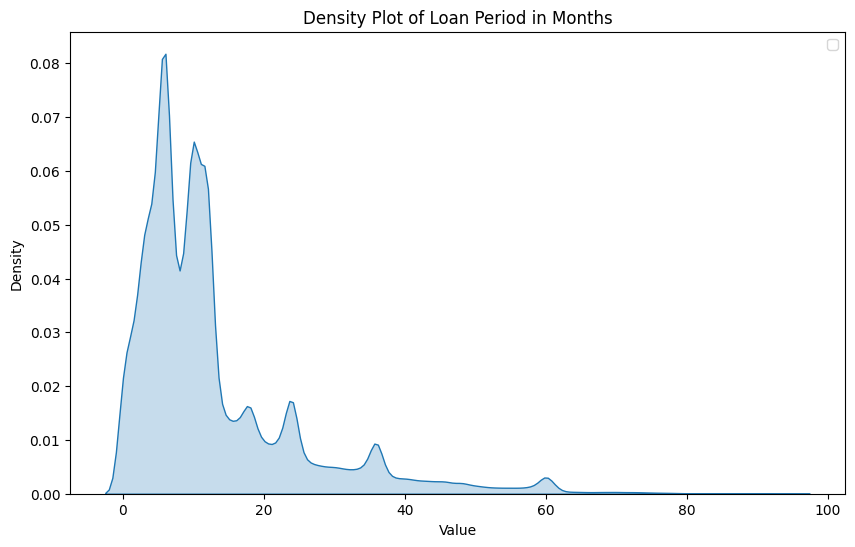

In [ ]:
# As per the following plot, I will choose 100 as the standard length of every 

plt.figure(figsize=(10, 6))
sns.kdeplot(dropped_null['duration_payment_hist'], label='', fill=True)
plt.title('Density Plot of Loan Period in Months')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
dropped_null = dropped_null[dropped_null['duration_in_months'] >= 0]
dropped_null.describe()

,loan_amount,amount_overdue,target,duration_in_months,duration_payment_hist,difference
count,7.822620e+05,7.822620e+05,782262.000000,782262.000000,782262.000000,782262.000000
mean,2.461442e+05,3.662965e+00,0.069610,13.027368,13.028978,0.001609
std,9.549769e+05,2.254929e+03,0.254488,12.310105,12.311670,0.161476
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,4.347000e+04,0.000000e+00,0.000000,6.000000,6.000000,0.000000
50%,9.162000e+04,0.000000e+00,0.000000,10.000000,10.000000,0.000000
75%,2.250000e+05,0.000000e+00,0.000000,16.000000,16.000000,0.000000
max,3.960000e+08,1.851210e+06,1.000000,95.000000,95.000000,31.000000


In [ ]:
dropped_null.columns

Index(['credit_type', 'loan_amount', 'amount_overdue', 'open_date',
       'closed_date', 'payment_hist_string', 'uid', 'contract type', 'target',
       'duration_in_months', 'duration_payment_hist', 'difference'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import StandardScaler

dataloading_df = dropped_null.copy()
dataloading_df = dataloading_df.sort_values('open_date')

# One-hot encoding  Nominal features
encodings = pd.get_dummies(dataloading_df[['credit_type', 'contract type']], prefix=['credit', 'contract'])
dataloading_df = pd.concat([dataloading_df, encodings], axis=1)

# Features that require normalization, I will not normalize payment history as that would be taken care of within the RNN model
to_scale_cols = ['loan_amount', 'amount_overdue', 'duration_in_months', 'duration_payment_hist', 'difference'] 
scaler_dict = {
    col: StandardScaler()
    for col in to_scale_cols
}

for col in to_scale_cols:
    dataloading_df[col] = [x[0] for x in scaler_dict[col].fit_transform([[x] for x in dataloading_df[col]])]

dataloading_df['payment_hist_list'] = dataloading_df['payment_hist_string'].map(process_payment_hist)

# Dropping unnecessary columns
dataloading_df = dataloading_df.drop(['credit_type', 'contract type', 'open_date', 'closed_date', 'payment_hist_string'], axis=1)

print(dataloading_df.shape)
dataloading_df.sample(10)

(782262, 24)


,loan_amount,amount_overdue,uid,target,duration_in_months,duration_payment_hist,difference,credit_Another type of loan,credit_Car loan,credit_Cash loan (non-earmarked),...,credit_Loan for purchase of shares (margin lending),credit_Loan for the purchase of equipment,credit_Loan for working capital replenishment,credit_Microloan,credit_Mortgage,credit_Real estate loan,credit_Unknown type of loan,contract_Cash loans,contract_Revolving loans,payment_hist_list
106605,2.211422,-0.001624,CFT17675924,0,-0.083457,-0.083577,-0.009967,0,0,0,...,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 13, 43, 73, 0, 0, 0]"
492362,-0.068085,-0.001624,KGQ99652109,1,-0.489628,-0.489696,-0.009967,0,0,0,...,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0]"
170613,-0.243277,-0.001624,DOK80808602,0,-0.814564,-0.814592,-0.009967,0,0,0,...,0,0,0,0,0,0,0,1,0,"[0, 0, 0]"
316434,-0.160872,-0.001624,GOR43638017,0,0.891352,0.891108,-0.009967,0,0,0,...,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
454889,-0.224764,-0.001624,JLX21454297,0,-0.977033,-0.977039,-0.009967,0,0,0,...,0,0,0,0,0,0,0,1,0,[0]
791276,-0.222222,-0.001624,QMZ29234995,0,-0.245926,-0.246025,-0.009967,0,0,0,...,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
187933,-0.203748,-0.001624,DYA12294334,0,-0.570862,-0.570920,-0.009967,0,0,0,...,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0]"
643728,-0.023696,-0.001624,NLV96671605,1,-0.083457,-0.083577,-0.009967,0,0,0,...,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
875738,-0.227214,-0.001624,SHD40615629,0,-0.814564,-0.814592,-0.009967,0,0,0,...,0,0,0,0,0,0,0,1,0,"[0, 0, 0]"
457778,0.684683,-0.001624,JNM73078079,0,3.734547,3.733941,-0.009967,0,0,0,...,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
dataloading_df.columns.tolist()

['loan_amount',
 'amount_overdue',
 'uid',
 'target',
 'duration_in_months',
 'duration_payment_hist',
 'difference',
 'credit_Another type of loan',
 'credit_Car loan',
 'credit_Cash loan (non-earmarked)',
 'credit_Consumer credit',
 'credit_Credit card',
 'credit_Interbank credit',
 'credit_Loan for business development',
 'credit_Loan for purchase of shares (margin lending)',
 'credit_Loan for the purchase of equipment',
 'credit_Loan for working capital replenishment',
 'credit_Microloan',
 'credit_Mortgage',
 'credit_Real estate loan',
 'credit_Unknown type of loan',
 'contract_Cash loans',
 'contract_Revolving loans',
 'payment_hist_list']

In [ ]:
import pickle

with open('scalers.pkl', 'wb') as f:
    pickle.dump(scaler_dict, f)

In [ ]:
dataloading_df.dtypes

loan_amount                                            float64
amount_overdue                                         float64
uid                                                     object
target                                                   int64
duration_in_months                                     float64
duration_payment_hist                                  float64
difference                                             float64
credit_Another type of loan                              uint8
credit_Car loan                                          uint8
credit_Cash loan (non-earmarked)                         uint8
credit_Consumer credit                                   uint8
credit_Credit card                                       uint8
credit_Interbank credit                                  uint8
credit_Loan for business development                     uint8
credit_Loan for purchase of shares (margin lending)      uint8
credit_Loan for the purchase of equipment              

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


# Making dataloader for ease of processing of the data
# To create tensor inputs, shapes for all the elements should be consistent
# For achieving that consistency, I will pad the data, i.e., 
# number of events per person would be padded to be of the length 120
# and number of months in the payment history will be of length 100 months (this extention will not affect the prediction negatively as I have added other features to give details about the duration of the loan period)
class LoanDataset(Dataset):
    def __init__(self, df, payment_hist_len=100, context_len=120):
        self.df = df.copy()
        self.df['payment_hist_list'] = self.df['payment_hist_list'].apply(lambda x: [0]*(payment_hist_len - len(x)) + x)
        self.grouped = self.df.groupby('uid')
        
        payment_hist = []
        features = []
        targets = []
        for _, group in tqdm(self.grouped):
            targets.append(group['target'].tolist()[0])
            payment_temp = group['payment_hist_list'].tolist()

            payment_hist.append(np.pad(payment_temp, ( (context_len-len(payment_temp), 0), (0, 0)) ))
            features.append(np.pad(group.drop(['payment_hist_list', 'uid'], axis=1).values, ( (context_len-len(payment_temp), 0), (0, 0))))

        print("Converting Features to tensors...")
        self.features = torch.tensor(features, dtype=torch.float32)
        print("Features converted to tensors")
        print("Converting Payment History to tensors...")
        self.payment_hist = torch.tensor(payment_hist, dtype=torch.float32)
        print('Converted Payment History to tensors.')
        print("Converting Features to tensors...")
        self.targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)
        print('Converted Targets to tensors.')
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.payment_hist[idx], self.targets[idx]

dataset = LoanDataset(dataloading_df.iloc[:10**5, :])

In [152]:
dataset.targets = torch.squeeze(dataset.targets, dim=0)

In [153]:
# Splitting the data for training and validation sets

from torch.utils.data import random_split

train_size = int(0.4 * len(dataset))
val_size = train_size
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score


class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.feature_embed = nn.Linear(22, 64) # Embedding layer for all the features other than payment history
        self.payment_embed = nn.Linear(100, 64) # Embedding layer for the payment history
        self.rnn = nn.RNN(128, 128, num_layers=2, batch_first=True) # 2 RNN layers of size 128
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, features, payment_hist):
        features = self.feature_embed(features)
        payment_hist = self.payment_embed(payment_hist)
        payment_hist = torch.tanh(payment_hist)
        
        combined = torch.cat((features, payment_hist), dim=-1)
        combined = torch.relu(combined)
        
        rnn_out, _ = self.rnn(combined)
        rnn_out = torch.relu(rnn_out[:, -1, :])
        
        x = self.fc1(rnn_out)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

model = RNNModel()

In [191]:
import os
from time import time

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

epochs = 10
best_auc = 0.0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    start = time()
    for features, payment_hist, targets in train_loader:
        
        optimizer.zero_grad()
        
        outputs = model(features, payment_hist)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    end = time()
    
    epoch_loss = running_loss / len(train_loader)
    
    scheduler.step()

    model.eval()
    val_targets = []
    val_preds = []
    with torch.no_grad():
        for features, payment_hist, targets in val_loader:
            
            outputs = model(features, payment_hist)
            
            val_targets.extend(targets.detach().numpy())
            val_preds.extend(outputs.detach().numpy())
    
    val_auc = roc_auc_score(val_targets, val_preds)
    
    scheduler.step()

    if val_auc > best_auc:
        best_auc = val_auc
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}_val_auc_{val_auc:.4f}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'val_auc': val_auc,
        }, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val AUC: {val_auc:.4f}, Time Take: {end-start:.4f}")

print("Training complete")

Checkpoint saved: ./checkpoints\checkpoint_epoch_1_val_auc_0.9989.pth
Epoch 1/10, Train Loss: 0.1570, Val AUC: 0.9989, Time Take: 35.8224
Checkpoint saved: ./checkpoints\checkpoint_epoch_2_val_auc_0.9997.pth
Epoch 2/10, Train Loss: 0.0058, Val AUC: 0.9997, Time Take: 33.4407
Checkpoint saved: ./checkpoints\checkpoint_epoch_3_val_auc_1.0000.pth
Epoch 3/10, Train Loss: 0.0026, Val AUC: 1.0000, Time Take: 34.6679
Checkpoint saved: ./checkpoints\checkpoint_epoch_4_val_auc_1.0000.pth
Epoch 4/10, Train Loss: 0.0019, Val AUC: 1.0000, Time Take: 34.2471
Checkpoint saved: ./checkpoints\checkpoint_epoch_5_val_auc_1.0000.pth
Epoch 5/10, Train Loss: 0.0018, Val AUC: 1.0000, Time Take: 34.0065
Checkpoint saved: ./checkpoints\checkpoint_epoch_6_val_auc_1.0000.pth
Epoch 6/10, Train Loss: 0.0017, Val AUC: 1.0000, Time Take: 34.0874
Checkpoint saved: ./checkpoints\checkpoint_epoch_7_val_auc_1.0000.pth
Epoch 7/10, Train Loss: 0.0017, Val AUC: 1.0000, Time Take: 37.3844
Checkpoint saved: ./checkpoints\ch

# Saving Processed data and resulting model

In [198]:
torch.save(dataset, 'data/Dataset.pth')
torch.save({
            'epoch': 10,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'saved_model/model_weights.pt')

In [10]:
dataset = torch.load('data/Dataset.pth')

In [14]:
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


model = RNNModel()
checkpoint = torch.load('saved_model/model_weights.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
actual = []
preds = []
with torch.no_grad():
    for features, payment_hist, targets in dataloader:
        
        outputs = model(features, payment_hist)
        
        actual.extend(targets.detach().numpy())
        preds.extend(outputs.detach().numpy())


In [27]:
roc_auc_score(actual, (np.array(preds)>0.5).astype(int))

0.0007081834593307993

# Creating Submission Pipeline

#### Making a pipeline for the inference

In [11]:
# Parameters required for the data for inference

ACCOUNTS_DATA_PATH = "data/test/accounts_data_test.json"
ENQUIRY_DATA_PATH = "data/test/enquiry_data_test.json"
CSV_PATH = "data/test/test_flag.csv"
MODEL_PATH = "saved_models/model_weights.pt"
SCALER_MODEL_PATH = "saved_models/scalers.pkl"
SUBMISSION_PATH = "data/final_submission/final_submission_Gauranshu.csv"

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import json
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score

c:\Users\gaura\anaconda3\envs\denv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class InferenceDataset(Dataset):
    def __init__(self, df, payment_hist_len=100, context_len=120):
        self.df = df.copy()
        self.df['payment_hist_list'] = self.df['payment_hist_list'].apply(lambda x: [0]*(payment_hist_len - len(x)) + x)
        self.grouped = self.df.groupby('uid')
        
        payment_hist = []
        features = []
        self.uids = []
        for _, group in tqdm(self.grouped):
            self.uids.append(group['uid'].tolist()[0])
            payment_temp = group['payment_hist_list'].tolist()

            payment_hist.append(np.pad(payment_temp, ( (context_len-len(payment_temp), 0), (0, 0)) ))
            features.append(np.pad(group.drop(['payment_hist_list', 'uid'], axis=1).values, ( (context_len-len(payment_temp), 0), (0, 0))))

        self.features = torch.tensor(features, dtype=torch.float32)
        self.payment_hist = torch.tensor(payment_hist, dtype=torch.float32)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.payment_hist[idx]

In [5]:
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score


class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.feature_embed = nn.Linear(22, 64)
        self.payment_embed = nn.Linear(100, 64)
        self.rnn = nn.RNN(128, 128, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, features, payment_hist):
        features = self.feature_embed(features)
        payment_hist = self.payment_embed(payment_hist)
        payment_hist = torch.tanh(payment_hist)
        
        combined = torch.cat((features, payment_hist), dim=-1)
        combined = torch.relu(combined)
        
        rnn_out, _ = self.rnn(combined)
        rnn_out = torch.relu(rnn_out[:, -1, :])
        
        x = self.fc1(rnn_out)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [5]:
def pipeline(accounts_data_path, enquiry_data_path, csv_path, submission_path):
    accounts_data_path = ACCOUNTS_DATA_PATH
    enquiry_data_path = ENQUIRY_DATA_PATH
    csv_path = CSV_PATH

    def process_date_features(date):
        if type(date) == float:
            return datetime(2021,1,1)
        return datetime(*map(int, date.split('-')))

    def process_payment_hist(payment_hist):
        payment_hist_list = [int(payment_hist[i:i+3]) for i in range(0, len(payment_hist), 3)]
        return payment_hist_list

    df = pd.read_csv(csv_path)
    desired_cols = ['loan_amount',
            'amount_overdue',
            'uid',
            'target',
            'duration_in_months',
            'duration_payment_hist',
            'difference',
            'credit_Another type of loan',
            'credit_Car loan',
            'credit_Cash loan (non-earmarked)',
            'credit_Consumer credit',
            'credit_Credit card',
            'credit_Interbank credit',
            'credit_Loan for business development',
            'credit_Loan for purchase of shares (margin lending)',
            'credit_Loan for the purchase of equipment',
            'credit_Loan for working capital replenishment',
            'credit_Microloan',
            'credit_Mortgage',
            'credit_Real estate loan',
            'credit_Unknown type of loan',
            'contract_Cash loans',
            'contract_Revolving loans',
            'payment_hist_list'
        ]


    uid2target = {
        row['uid']: {
        'contract type': row['NAME_CONTRACT_TYPE']
        } for i, row in df.iterrows()
    }

    with open(accounts_data_path, 'rb') as f:
        accounts_data = json.load(f)
    temp_dict = {
        k: [] for k in accounts_data[0][0].keys()
    }
    temp_dict['contract type'] = []

    for person in accounts_data:
        for acc in person:
            for k, v in acc.items():
                temp_dict[k].append(v)
            temp_dict['contract type'].append(uid2target[acc['uid']]['contract type'])

    accounts_df = pd.DataFrame(temp_dict)    

    dummy_data = np.zeros((accounts_df.shape[0], len(desired_cols)))
    dataloading_df = pd.DataFrame(columns=desired_cols, data=dummy_data)
        
    # with open(enquiry_data_path, 'rb') as f:
    #     enquiry_data = json.load(f)
    # temp_dict = {
    #     k: [] for k in enquiry_data[0][0].keys()
    # }
    # temp_dict['contract type'] = []
    # temp_dict['target'] = []

    # for person in enquiry_data:
    #     for enq in person:
    #         for k, v in enq.items():
    #             temp_dict[k].append(v)
    #         temp_dict['target'].append(uid2target[enq['uid']]['target'])
    #         temp_dict['contract type'].append(uid2target[enq['uid']]['contract type'])

    # enquiry_df = pd.DataFrame(temp_dict)

    duration_in_days = accounts_df['closed_date'].map(process_date_features) - accounts_df['open_date'].map(process_date_features)
    accounts_df['duration_in_months'] = duration_in_days.map(lambda x:x.days//30)
    accounts_df['duration_payment_hist'] = accounts_df['payment_hist_string'].map(lambda x:len(x)//3)
    accounts_df['difference'] = accounts_df['duration_payment_hist'] - accounts_df['duration_in_months']

    with open(SCALER_MODEL_PATH, 'rb') as f:
        scaler_dict = pickle.load(f)

    accounts_df.sort_values('open_date', inplace=True)

    encodings = pd.get_dummies(accounts_df[['credit_type', 'contract type']], prefix=['credit', 'contract'])
    accounts_df = pd.concat([accounts_df, encodings], axis=1)

    to_scale_cols = ['loan_amount', 'amount_overdue', 'duration_in_months', 'duration_payment_hist', 'difference'] 

    for col in to_scale_cols:
        accounts_df[col] = [x[0] for x in scaler_dict[col].transform([[x] for x in accounts_df[col]])]

    accounts_df['payment_hist_list'] = accounts_df['payment_hist_string'].map(process_payment_hist)
    accounts_df = accounts_df.drop(['credit_type', 'contract type', 'open_date', 'closed_date', 'payment_hist_string'], axis=1)

    for col in accounts_df.columns:
        if col in dataloading_df.columns:
            dataloading_df[col] = accounts_df[col]

    dataset = InferenceDataset(dataloading_df)

    batch_size = 64
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


    model = RNNModel()
    checkpoint = torch.load(MODEL_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    predictions = []
    with torch.no_grad():
        for features, payment_hist in dataloader:
            
            outputs = model(features, payment_hist)
            
            predictions.extend(outputs.detach().numpy())

    predictions = (np.array(predictions)>0.05).astype(int)

    submission_dict = {
        'uid': dataset.uids,
        'pred': [x[0] for x in predictions]
    }
    submission_df = pd.DataFrame(submission_dict)
    submission_df.to_csv(submission_path)

In [6]:
pipeline(ACCOUNTS_DATA_PATH, ENQUIRY_DATA_PATH, CSV_PATH, SUBMISSION_PATH)

100%|██████████| 39572/39572 [00:23<00:00, 1716.43it/s]
C:\Users\gaura\AppData\Local\Temp\ipykernel_1876\3191654946.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  self.features = torch.tensor(features, dtype=torch.float32)
